## Analysis of temporal frequency tuning

In [15]:
%matplotlib inline
import sys
sys.path.append("/Users/mmeier/Desktop/new_arena/")
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from scipy import stats
from tempfile import TemporaryFile
from os.path import split
import pylab
import data_analysis.tools as tools
import data_analysis.calcium_analysis as calcium_analysis

### Loading several ROIs at once:

There are several tools for in the *data_analysis.calcium_analysis* package for the analysis of several ROI at once. It is assumed that all these ROI come from the same imaging session (or from the same *.tiff file) which means that their names start all in the same way and they share one *.sti2-file which also has this name.

The variable *path* defines the common path of all ROIs that we want to load (and at the same time the name of the corresponding *.sti2, and *.png files belonging to that imaging session)

The function *get_all_experiment_data* takes that path and outputs a list with *ExperimentData*-object, a numpy-array with the mean calcium signal and a numpy-array with the ROI selections as binary masks in the same size as the imaging frame.

#### Baseline definition:

* The function *get_all_experiment_data* takes again an optional argument *baseline_samples* that defines which samples to take as baseline for each ROI.
* The function *apply_dff_window_algorithm* can be applied seperately to each element of the data list. 
    * IMPORTANT : This should be done only once, since it changes the *ExperimentData* objects in the cache. Either you take care that this function is executed only once, or you write it into the same cell (in a Python Notebook) where you also load the data from the *.bin-files, so that each time you execute this cell the old data in the cache is overwritten

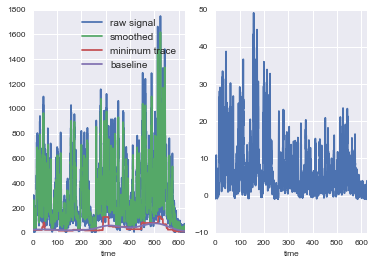

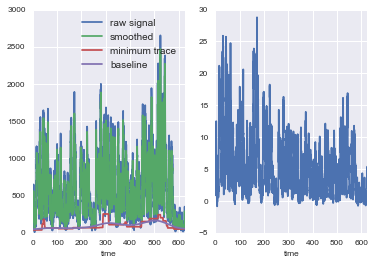

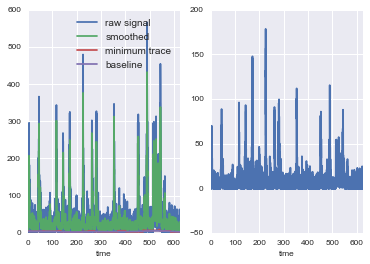

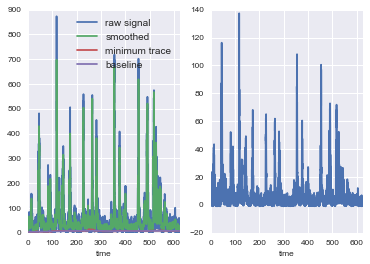

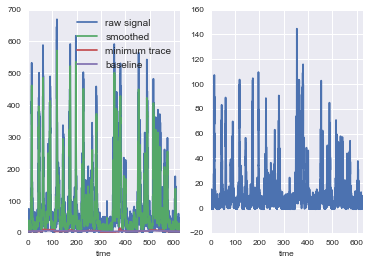

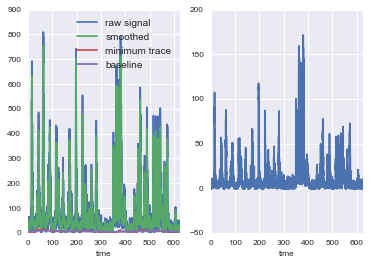

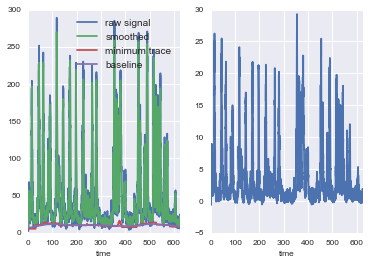

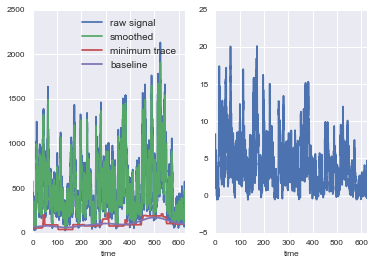

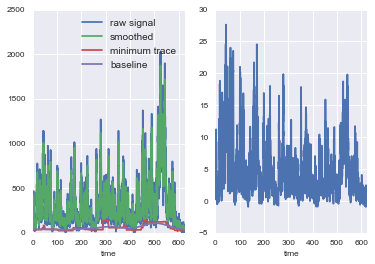

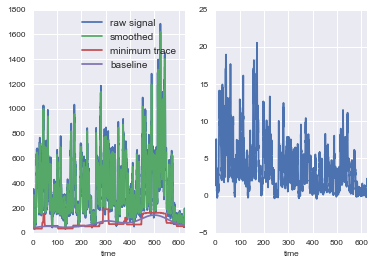

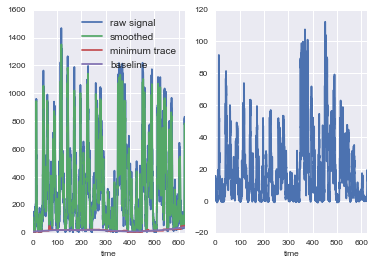

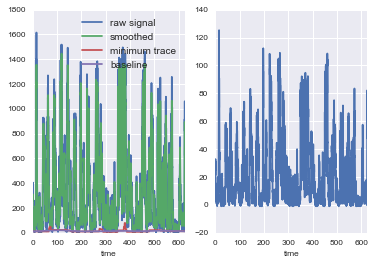

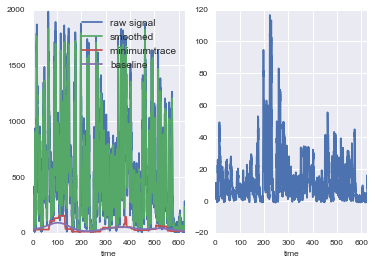

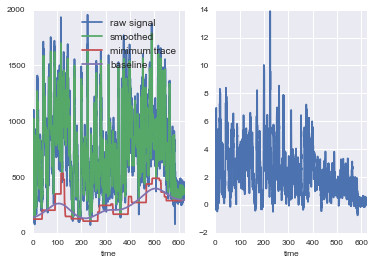

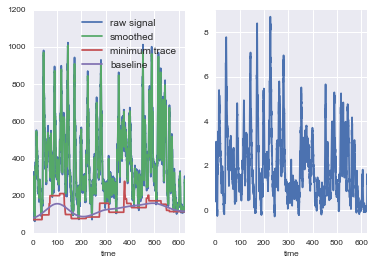

In [16]:
path = "roi_selected//T4T5_ctrl_temp_freq_PDND_2016-11-15_18.13"

name_of_file = split(path)[-1]

list_E, mean_signal, roi_masks = calcium_analysis.get_all_experiment_data(path)
for E in list_E:
    calcium_analysis.apply_dff_window_algorithm(E, plot = True)


### Example: evaluating several ROIs at once (tuning curve)

Now you have a list called *list_E* which contains all pre-processed data. You can access single ROIs via list_E[i], where i is some integer within the range, and analyze them as you want.

For doing the same analysis for all ROIs, it makes sense to define functions that you can repeat easily.

Here, we want to do the same plot as in the single-ROI script, just for each ROI, and show the ROI selection alongside, to decide then which ROIs we want to select for further analysis.

For that, we define a function that plots A) the single traces for each ROI, B) the tuning curve for all stimulation frequencies, C) the ROI selection in the mean signal.

We want this function to output the individual tuning curve for this ROI, so that we later can plot a mean tuning curve

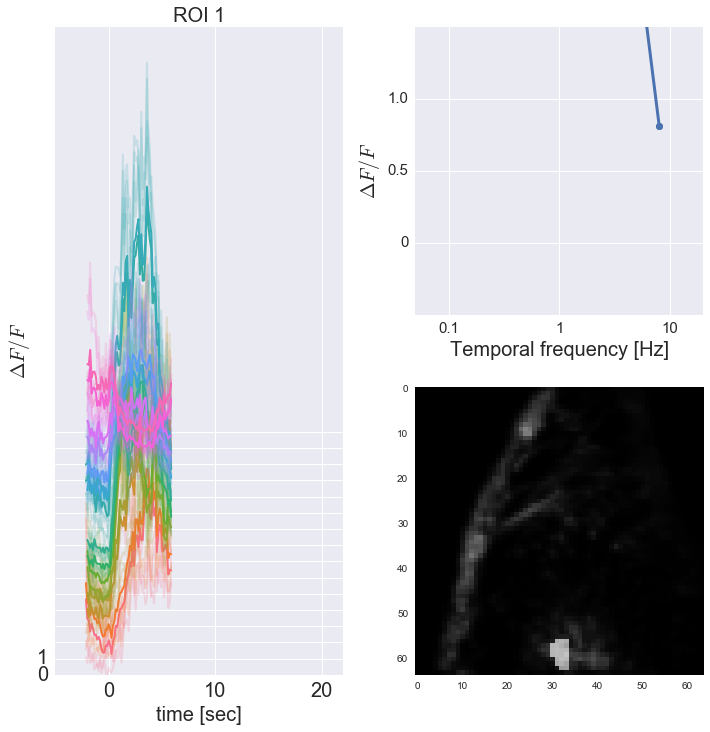

In [3]:
# define a function with all arguments that we need: the data, the mean signal, the roi selection mask, some title or name
def make_all_frequencies_plot(E, mean_signal, roi_mask, title = "no title"):
    
    # get all orientations that were presented
    Geschwindigkeit = E.d_stimulus_parameters['velocity [deg/s]'].values
    Geschwindigkeit = np.sort(Geschwindigkeit)
    
    # initialize storage array for the evaluated ata
    frequency_response = np.zeros(len(Geschwindigkeit))

    # PLOT1: plot the single traces for each stimulation orientation (and get the tuning curve at the same time)
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_axes([0.1,0.1,0.4,0.9]) 
    colors = sb.color_palette('husl', len(Geschwindigkeit))

    # go through all orientations and extract the corresponding data
    for i in range(len(Geschwindigkeit)):
        offset = i*1
        vel = Geschwindigkeit[i]
        data, sti_data, N, params_dict, h = E.get_by_stimulus_parameters([('name', 'stimuli.default.Grating'),
                                                                          ('rotation [deg]', 90.0), ('velocity [deg/s]', vel)])

        # get the mean value and plot a thick solid line
        # NOTE: the "loc" command of a pandas.DataFrame localizes elements within the DataFrame. The first parameter 
        # refers to the y-axis (here the sample number) and the second parameter to the column name.
        # For more information read the pandas-Documentation, forums etc...
        plt.plot(data['time'], data.loc[:, 'mean'] + offset, color = colors[i], linewidth = 2.0)

        # get the single trials and plot them with an alpha value of 0.2
        plt.plot(data['time'], data.loc[:, '0':] + offset, color = colors[i], alpha = 0.2, linewidth = 2.0)
        
        # evaluate the mean response during the stimulation period
        frequency_response[i] = data.set_index('time').loc[0:10, 'mean'].mean()


    # define yticks
    plt.yticks(np.arange(len(Geschwindigkeit)))
    ax.set_yticklabels([0, 1] + ['' for i in range(2, len(Geschwindigkeit))], fontsize = 20.)
    ax.set_ylabel('$\Delta F /F$', fontsize = 20.)

    # define xticks
    plt.xlim([-5,22])
    plt.xticks([0,10,20])
    ax.set_xticklabels([0, 10, 20], fontsize = 20.)
    ax.set_xlabel('time [sec]', fontsize = 20.)
    
    # plot some title or name above it, so that we can identify the ROI
    ax.set_title(title, fontsize = 20.)
    
    
    # PLOT2: SHOW THE TUNING CURVE
    ax = fig.add_axes([0.6,0.6,0.4,0.4]) 
    
    # define the x-axis and plot everything on a log-scale
    stimulus_frequency = Geschwindigkeit / np.unique(E.d_stimulus_parameters['wavelength [deg]'].values)
    plt.plot(stimulus_frequency, frequency_response, linewidth = 3.0, marker = 'o')
    plt.xscale('log')

    # define the x-axis and ticks etc...
    ax.set_xlim([0.05,20])
    ax.set_xticks([0.1,1.,10])
    ax.set_xticklabels([0.1,1,10], fontsize = 15.)
    ax.set_xlabel('Temporal frequency [Hz]', fontsize = 20.)

    # define the y-axis and ticks etc...
    plt.ylim([0,2])
    ax.set_yticks([0.5, 1.0,1.5])
    ax.set_yticklabels([0, 0.5, 1.0], fontsize = 15.)
    ax.set_ylabel('$\Delta F/F$', fontsize = 20.)
    
    
    #PLOT3: SHOW THE ROI SELECTION
    ax = fig.add_axes([0.6,0.1,0.4,0.4])
    # show the mean signal 
    ax.imshow(mean_signal, cmap = plt.get_cmap('Greys_r'), interpolation = 'nearest')
    # show the roi selection as an overlay with slight transparency
    ax.imshow(1-roi_mask, alpha = 0.5, interpolation = 'nearest')
    ax.grid(False)
    
    return frequency_response
    

    
# EXAMPLE USAGE:
i = 1
frequecy_response = make_all_frequencies_plot(list_E[i], mean_signal, roi_masks[:,:,i], title = "ROI " + str(i))


#### Choosing ROIs

Now, we just execute that function for each element of *list_E* so that we can look at the data and choose later which ROIs we would like to keep for the final analysis.
At the same time, we save the tuning curve for each ROI in a list called *list_tunings* so that we can work with that later.


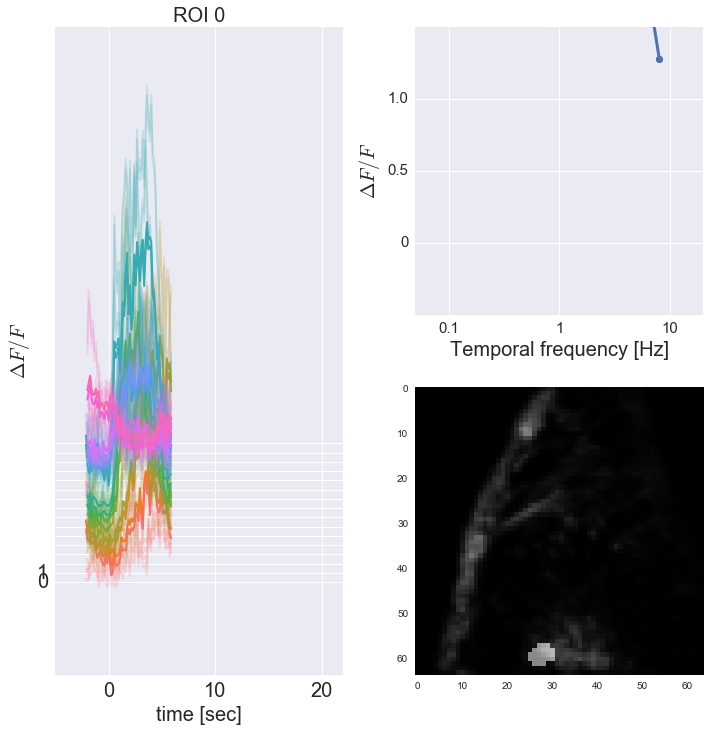

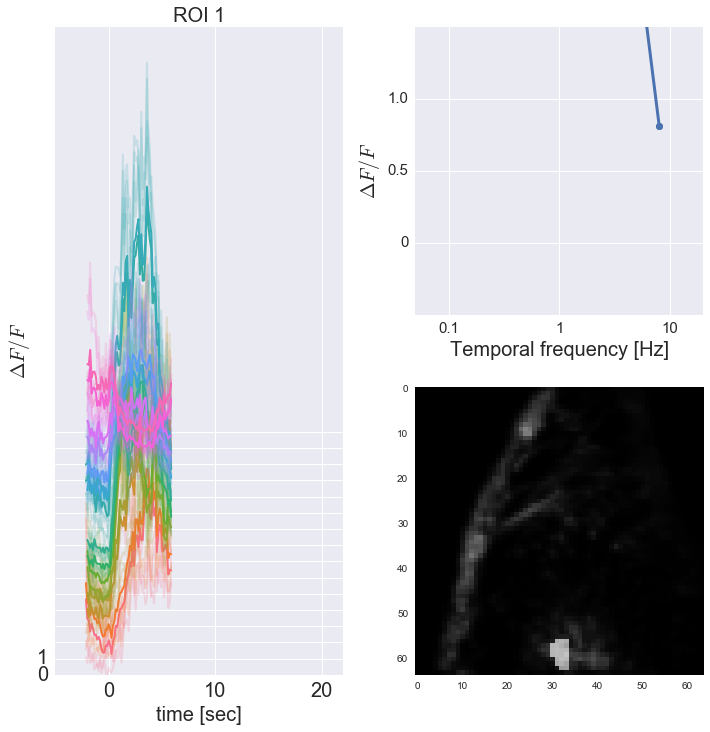

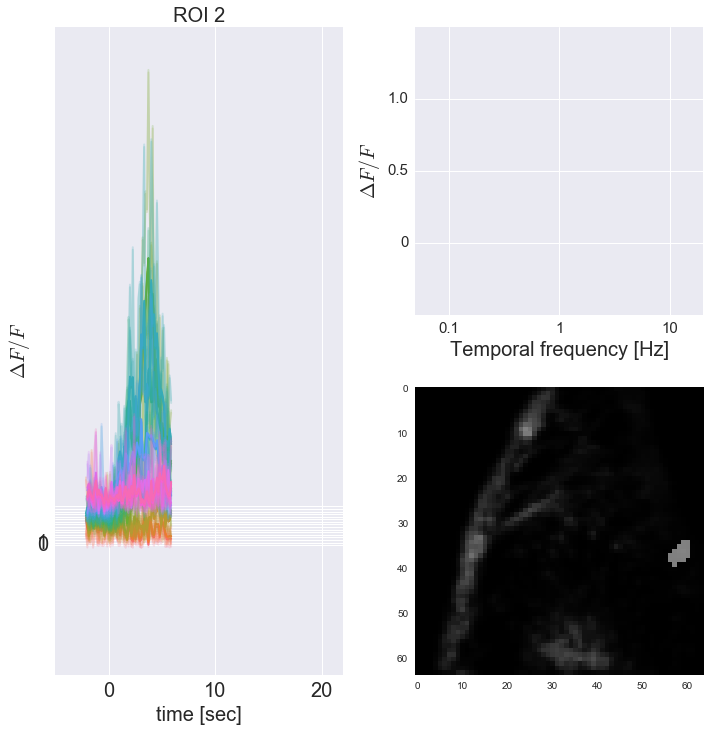

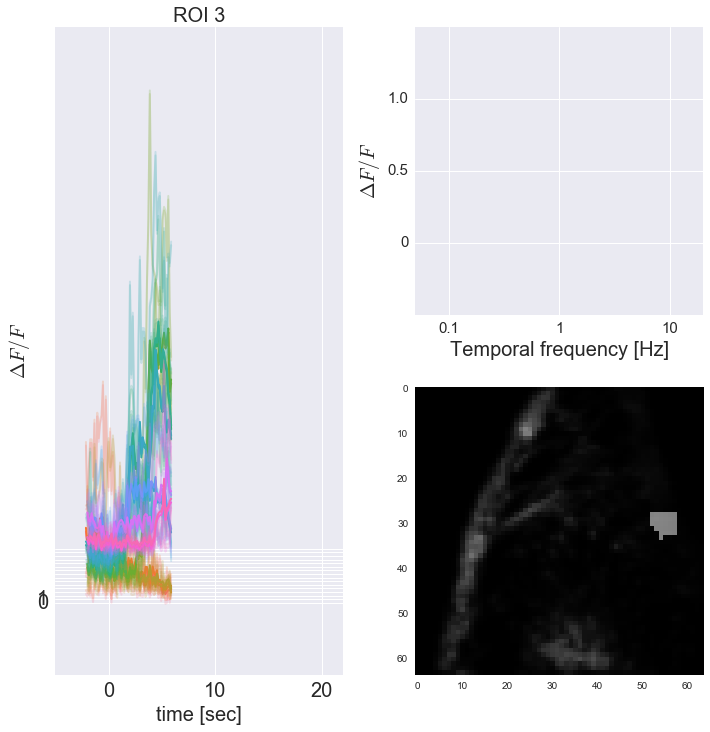

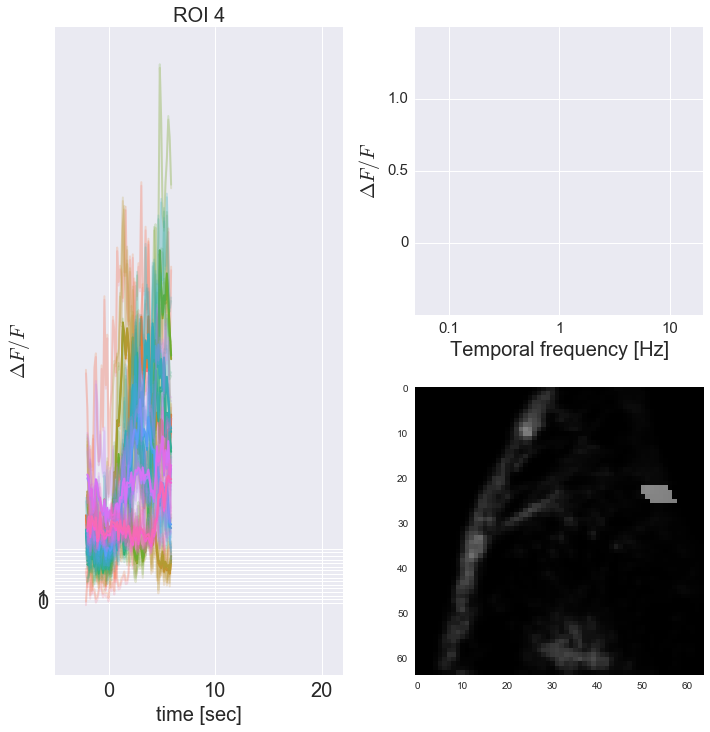

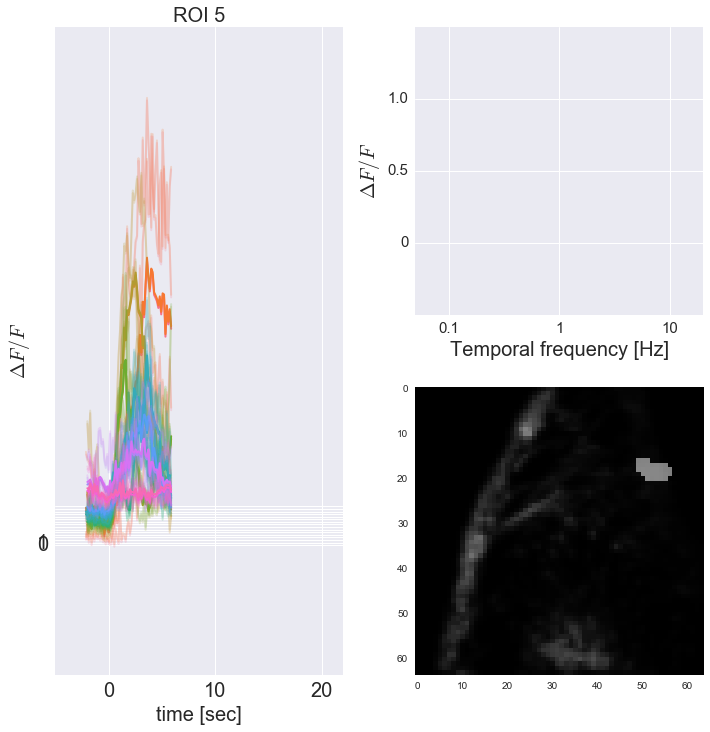

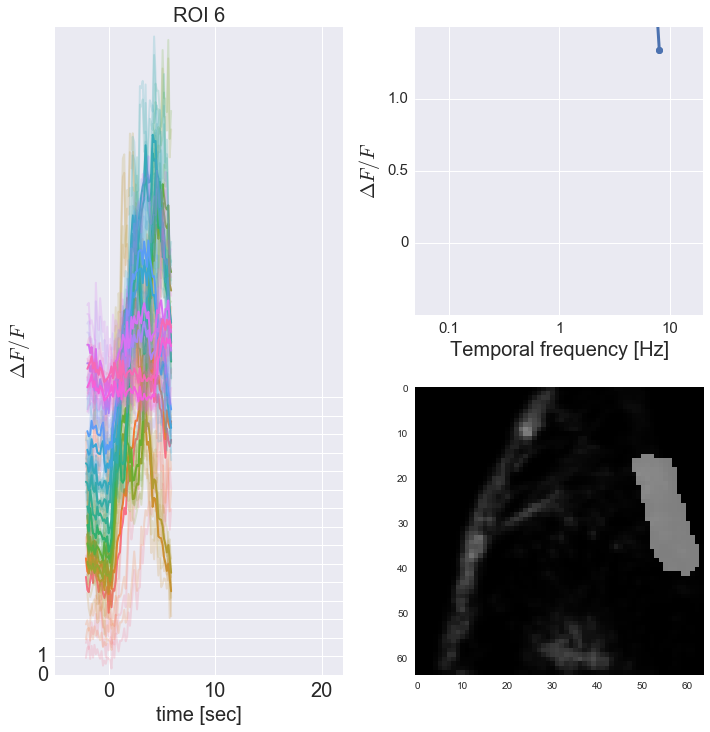

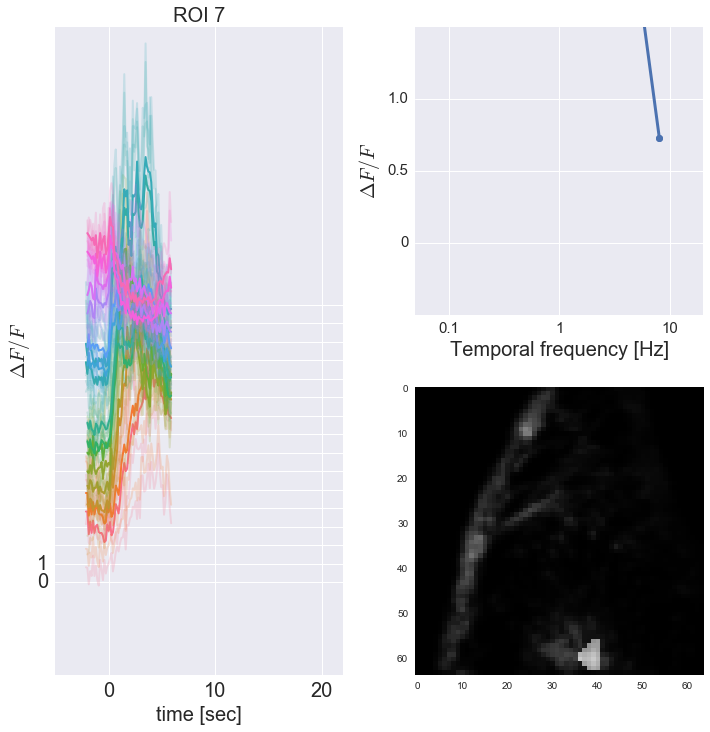

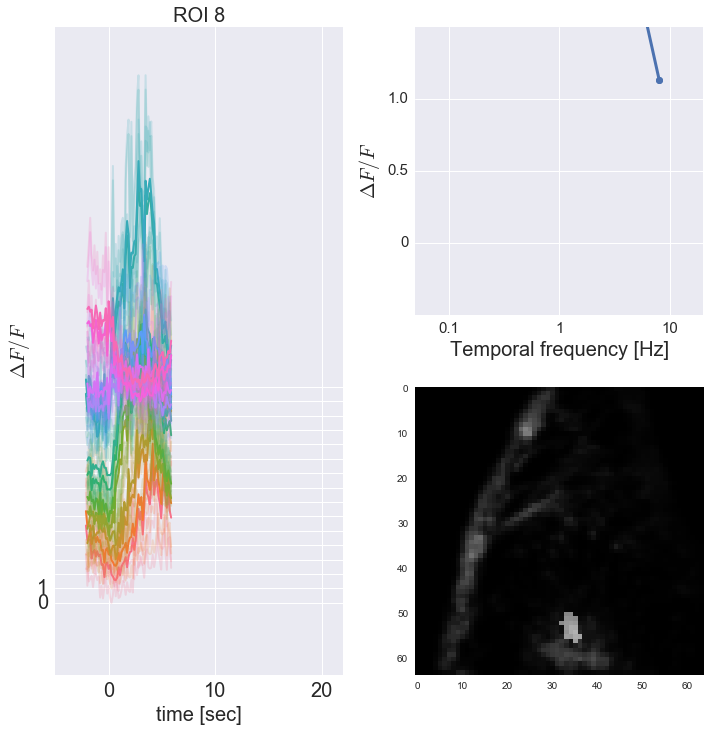

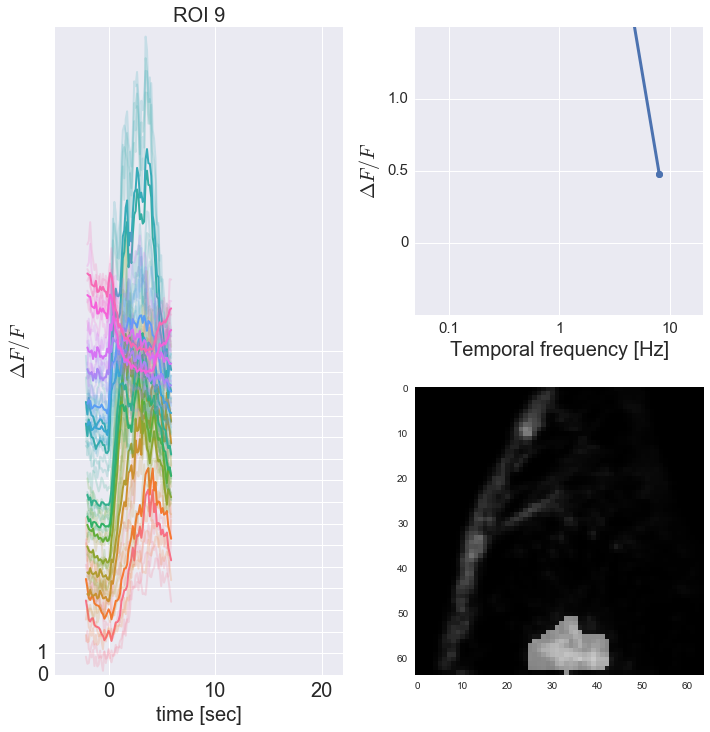

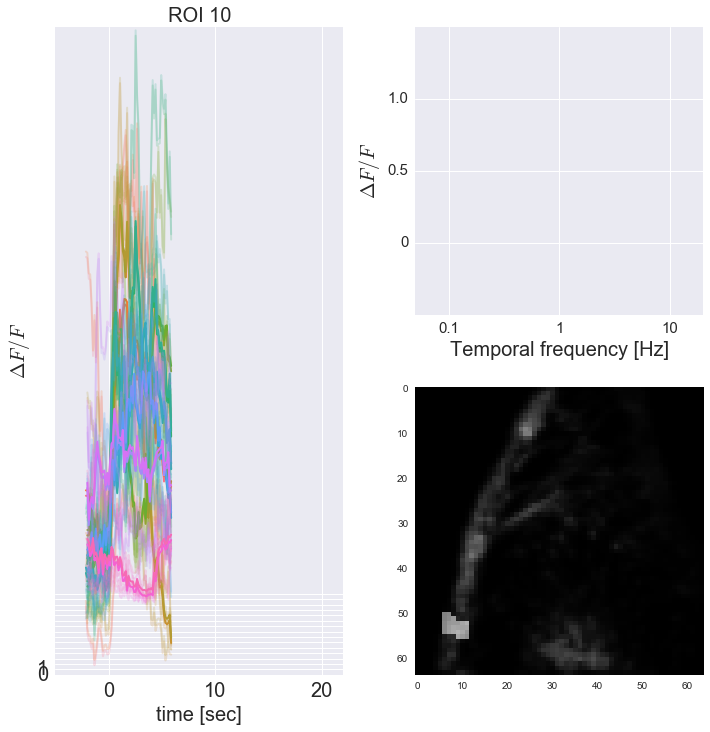

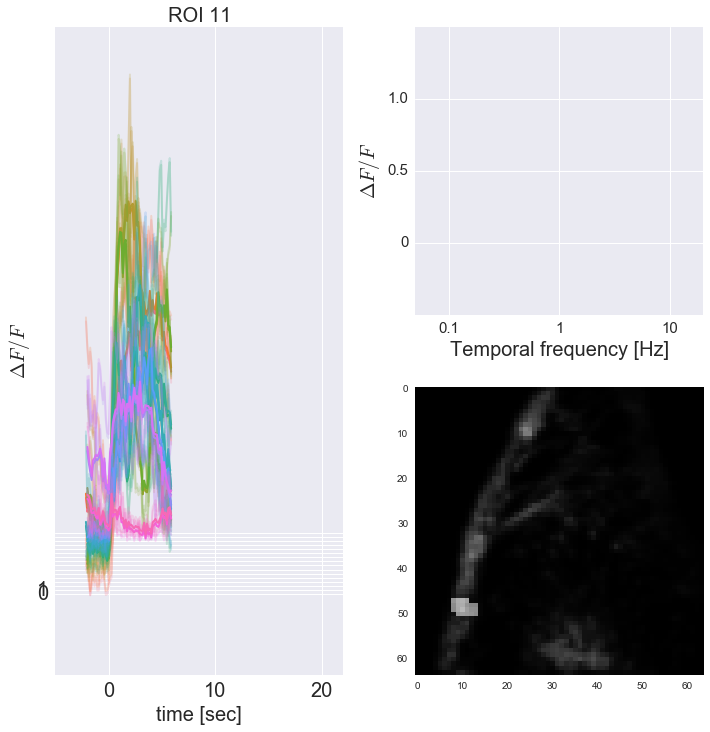

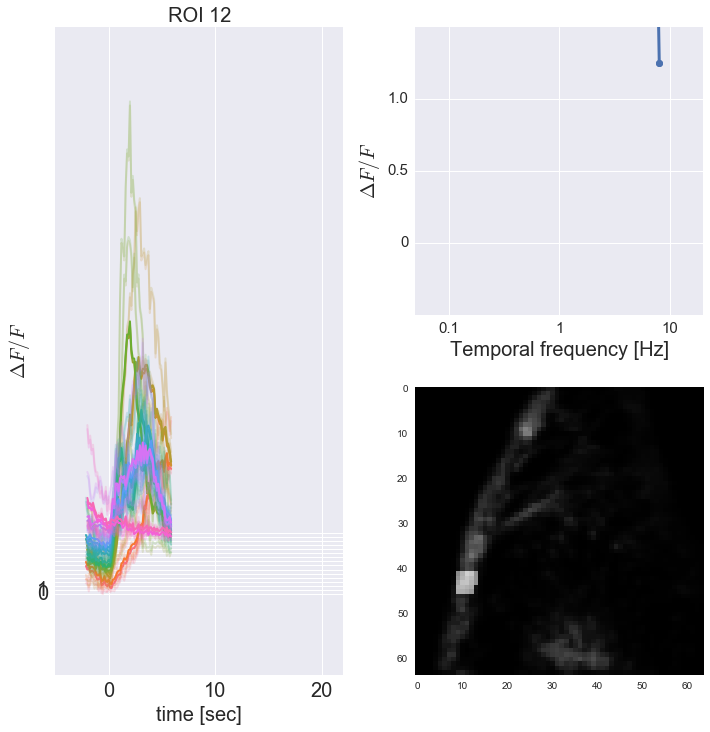

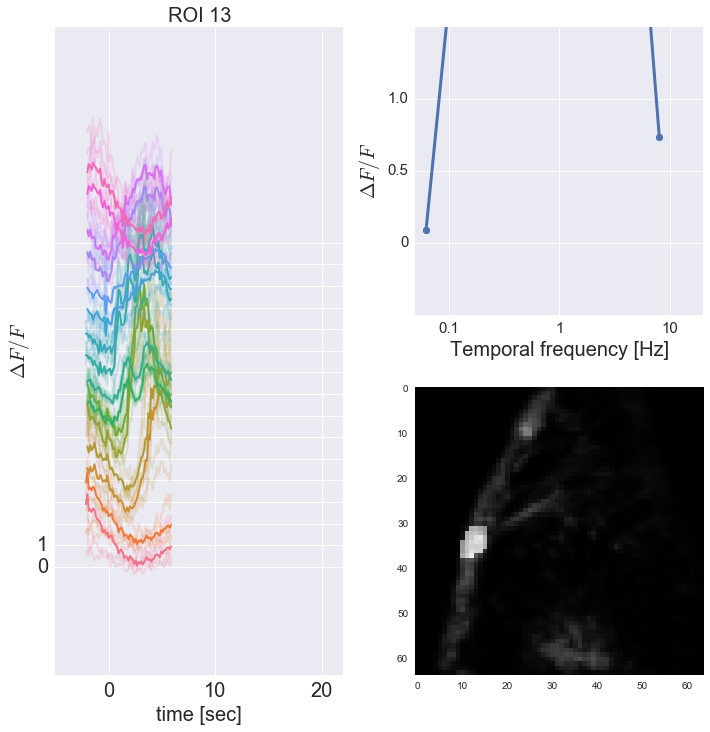

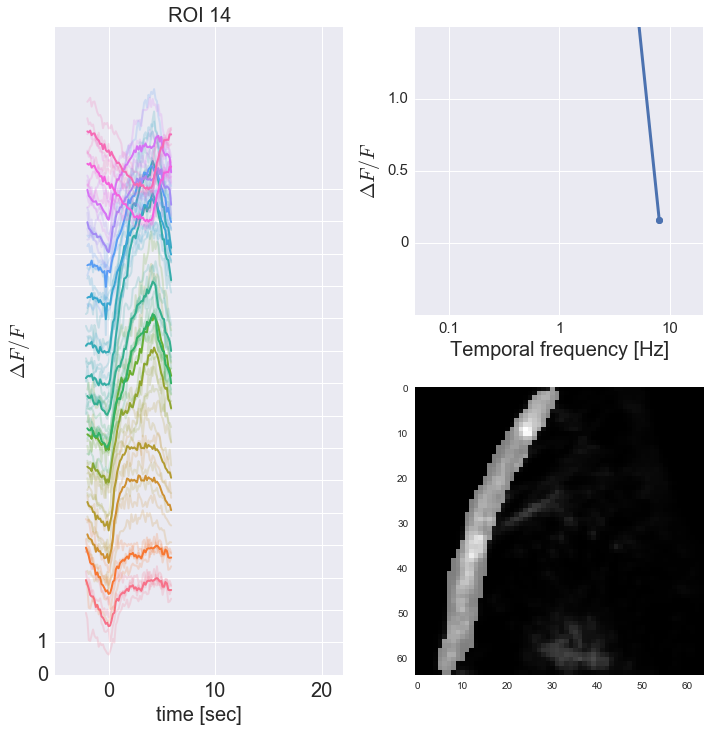

In [4]:
list_tunings = []
for i in range(len(list_E)):
    frequency_response = make_all_frequencies_plot(list_E[i], mean_signal, roi_masks[:,:,i], title = "ROI " + str(i))
    list_tunings.append(frequency_response)

#### Calculating a mean tuning curve

In this example, all ROIs seem to have responded nicely.

However, for demonstration, we define a list with the indices of the ROIs (the elements of *list_E*) that we would like to take for further analysis. 

We call this list *take*.

Then we just take all the elements with those indices from the list of tuning curves *list_tunings* (which we generated just in the last command) and store them in a numpy matrix with the rows corresponding to the stimulation frequencies and the columns corresponding to the ROIs.

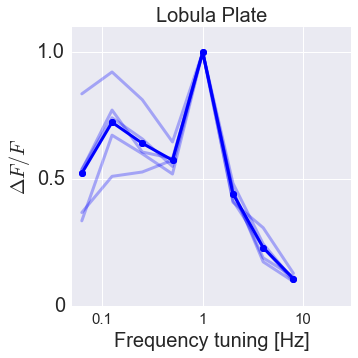

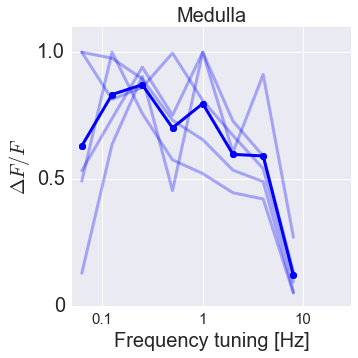

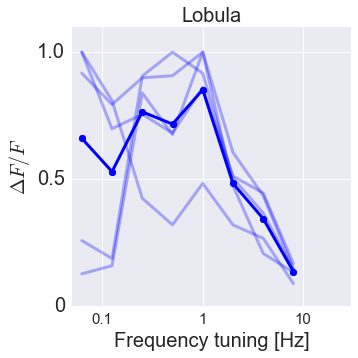

In [14]:
take_regions = np.array([[0,1,7,8,9],[10,11,12,13,14],[2,3,4,5,6]])
number_of_regions = [0,1,2]
for regions in number_of_regions:

    take = take_regions[regions,:]

    N = len(list_tunings[0]) # number of stimulation frequencies
    M = len(take) # number of ROIs, that we take for further analysis
    mean_tuning = np.zeros((N,M)) # initialize empty matrix?    

    for i in range(len(take)):
        mean_tuning[:,i] = list_tunings[take[i]]

    # normalization
    for i in range(len(take)):
        mean_tuning[:,i] = mean_tuning[:,i]/mean_tuning[:,i].max()


    # plot everything
    plt.figure(figsize = (5,5))
    ax = plt.subplot(111)

    # here, we manually define the x-axis
    frequency_tuning = E.d_stimulus_parameters['velocity [deg/s]'].values/E.d_stimulus_parameters['wavelength [deg]'].values
    frequency_tuning = np.sort(frequency_tuning)

    # plot mean tuning as solid line
    plt.plot(frequency_tuning, mean_tuning.mean(1), color = 'b', linewidth = 3.0, marker = 'o')

    # plot single tunings with a lower alpha
    plt.plot(frequency_tuning, mean_tuning, color = 'b', linewidth = 3.0, alpha = 0.3)
    plt.xscale('log')

    # define the x-axis and ticks etc...
    ax.set_xlim([0.05,30])
    ax.set_xticks([0.1,1.,10.])
    ax.set_xticklabels([0.1, 1, 10], fontsize = 15.)
    ax.set_xlabel('Frequency tuning [Hz]', fontsize = 20.)

    # define the y-axis and ticks etc...
    plt.ylim([0,1.1])
    ax.set_yticks([0.0, 0.5, 1.0])
    ax.set_yticklabels([0, 0.5, 1.0], fontsize = 20.)
    ax.set_ylabel('$\Delta F/F$', fontsize = 20.)
    
    if regions == 0:
        plt.title ("Lobula Plate", fontsize = 20.)
        open(name_of_file + 'LP.npy','w')
        np.save(name_of_file + 'LP.npy', mean_tuning)
        pylab.savefig(name_of_file + 'LP.png')
    elif regions == 1:
        plt.title ("Medulla", fontsize = 20.)
        open(name_of_file + 'ME.npy','w')
        np.save(name_of_file + 'ME.npy', mean_tuning)
        pylab.savefig(name_of_file + 'ME.png')
    elif regions == 2:
        plt.title ("Lobula", fontsize = 20.)
        open(name_of_file + 'LO.npy','w')
        np.save(name_of_file + 'LO.npy', mean_tuning)
        pylab.savefig(name_of_file + 'LO.png')